In [5]:
# This builds the soccerutils module in the Analytics Handbook so you can import it
!pip install git+https://github.com/devinpleuler/analytics-handbook.git

  Cloning https://github.com/devinpleuler/analytics-handbook.git to /private/var/folders/80/yvvkwzb53hx627knh8c8w92w0000gn/T/pip-req-build-kif7j8lc
  Running command git clone --filter=blob:none -q https://github.com/devinpleuler/analytics-handbook.git /private/var/folders/80/yvvkwzb53hx627knh8c8w92w0000gn/T/pip-req-build-kif7j8lc
  Resolved https://github.com/devinpleuler/analytics-handbook.git to commit 00506db9fe5fe704b565ff6e1aa465c1806df15d
  Preparing metadata (setup.py) ... done
Using legacy 'setup.py install' for AnalyticsHandbook, since package 'wheel' is not installed.
    Running setup.py install for AnalyticsHandbook ... done
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3 -m pip install --upgrade pip' command.


In [6]:
from soccerutils.statsbomb import get_events
from soccerutils.pitch import Pitch

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [8]:
wc_final_match_id = 8658
raw_events = get_events(match_id=wc_final_match_id)

In [20]:
lineups = raw_events[0:2]
team_lineup = lineups[1] # Modulate the 1 between [0,1] for [home,away]
team_id = team_lineup['team']['id'] 

In [21]:
starters = {p['player']['id']: {"name": p['player']['name'],
                                "jersey": p['jersey_number']} for p in team_lineup['tactics']['lineup']}

In [22]:
events = [e for e in raw_events if e['team']['id'] == team_id]
passes = [e for e in raw_events if 'pass' in e.keys()]

In [23]:
matrix = {}
for p in passes:
    if 'outcome' not in p['pass'].keys():
        passer_id = p['player']['id']
        recipient_id = p['pass']['recipient']['id']
        
        a, b = sorted([passer_id, recipient_id]) # <-- Note
        
        if a not in matrix.keys():
            matrix[a] = {}
            
        if b not in matrix[a].keys():
            matrix[a][b] = 0
            
        matrix[a][b] += 1  

In [24]:
positions = {}
for e in events:
    
    if 'player' in e.keys():
        player_id = e['player']['id']
        if player_id not in positions.keys():
            positions[player_id] = {"x":[], "y":[]}
            
        if 'location' in e.keys():
            positions[player_id]['x'].append(e['location'][0])
            positions[player_id]['y'].append(80-e['location'][1])
            
avg_positions = {k:[np.mean(v['x']),np.mean(v['y'])] for k, v in positions.items() if k in starters.keys()}

In [25]:
lines = []
weights = []
for k, v in matrix.items():
    if k in starters.keys():
        origin = avg_positions[k]
        for k_, v_ in matrix[k].items():
            if k_ in starters.keys():
                dest = avg_positions[k_]
                lines.append([*origin, *dest])
                weights.append(v_)

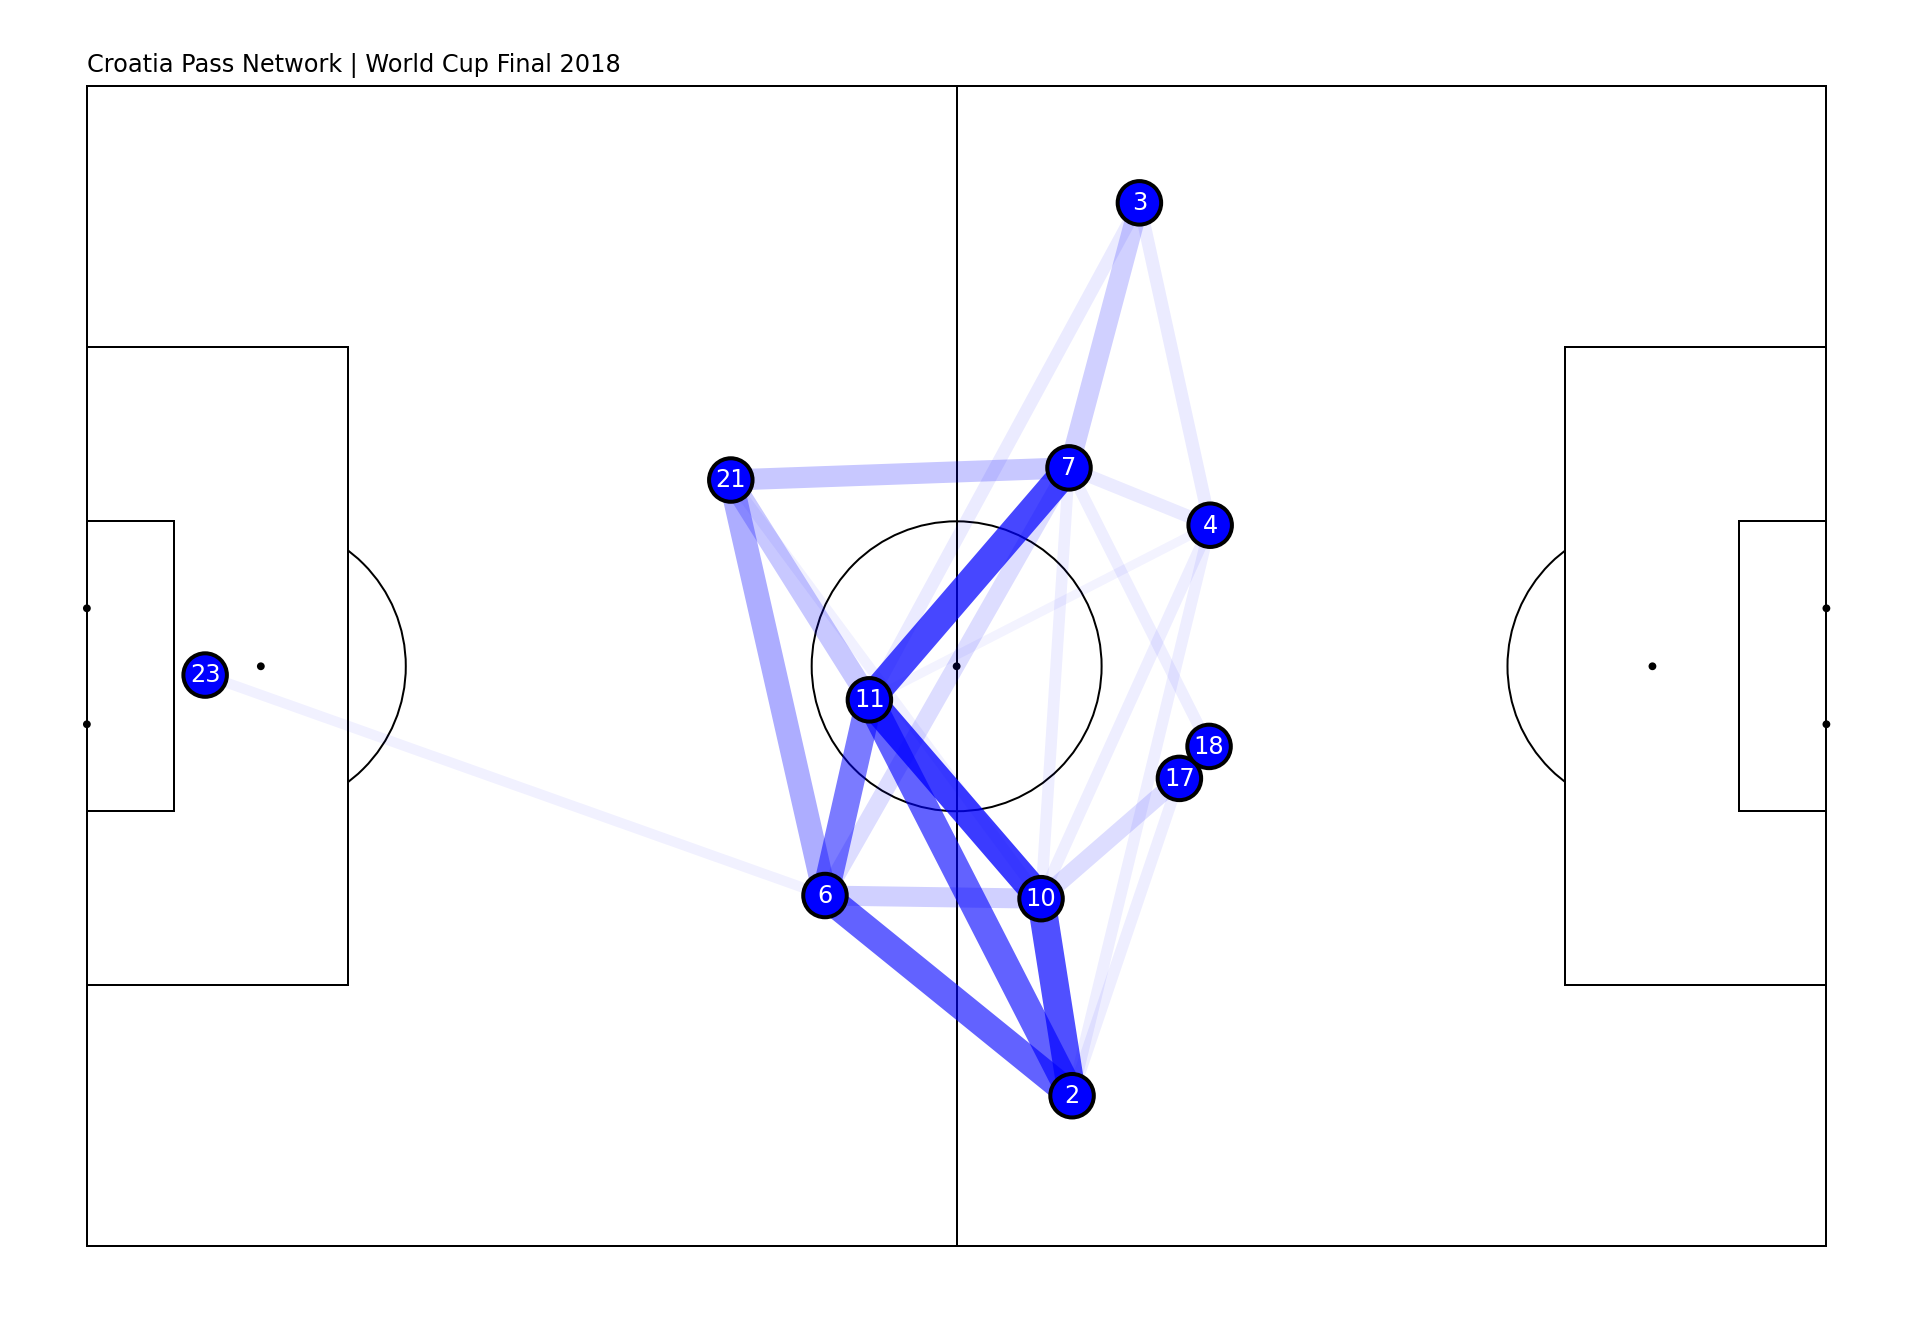

In [26]:
fig, ax = plt.subplots(figsize=(20, 12))
ax.set_aspect(1)
pitch = Pitch(title="Croatia Pass Network | World Cup Final 2018")
pitch.create_pitch(ax)

fill_adj = lambda x: 0.8 / (1 + np.exp(-(x-20)*0.2))
weight_adj = lambda x: 2 / (1 + np.exp(-(x-10)*0.2))

for i, e in enumerate(lines):
    
    cosmetics = {
        'width': weight_adj(weights[i]),
        'head_width': 0,
        'head_length': 0,
        'facecolor': (0, 0, 1, fill_adj(weights[i])),
        'edgecolor': (0, 0, 0, 0)
    }
    if weights[i] > 5:
        pitch.draw_lines(ax, [e], cosmetics=cosmetics)


cosmetics = {
    'linewidth': 2,
    'facecolor': (0, 0, 1, 1),
    'edgecolor': (0, 0, 0, 1),
    'radius': 1.5
}
pitch.draw_points(ax, [xy for k, xy in avg_positions.items()], cosmetics=cosmetics)

for k, v in avg_positions.items():
    jersey = starters[k]['jersey']
    x,y = v
    
    ax.text(pitch.x_adj(x), pitch.y_adj(y),
            jersey, fontsize=12,
            ha='center', va='center',
            color='white')


plt.ylim(pitch.ylim)
plt.xlim(pitch.xlim)
plt.axis('off')
plt.show()